<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelowanie krzywej OIS - przykład rynku GBP

# Wstęp

W tym notebooku prezentujemy model dla krzywej OIS rynku dłużnego funta.
Pokazujemy, że stopa OIS zależy od indexu SONIA, który natomiast jest zależny od stopy referencyjnej centralnego banku Wielkiej Brytanii.

Prezentujemy uproszczony model Hulla-White'a do symulacji indexu SONIA, co pozwala na ujęcie prognoz eksperckich co do zmian stopy referencyjnej. Pokazujemy również zastosowanie modelu PCA i pivots do modelowania ruchów krzywej OIS.

Cały model pozwala na symulację Monte Carlo ruchow krzywej OIS.

In [52]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
from typing import Callable, Optional
from datetime import date
from sklearn.datasets import make_blobs

sns.set()
sns.set_context('talk')
#sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['figure.figsize'] = (10, 8)

# Dane

Dane dzienne dotyczące [OIS](https://www.bankofengland.co.uk/statistics/yield-curves) i [SONIA](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N) są publicznie dostępne na stronie Bank of England. 

Do dyspozycji mamy 6 lat dziennych obserwacji SONII oraz 60 tenorów krzywej OIS.


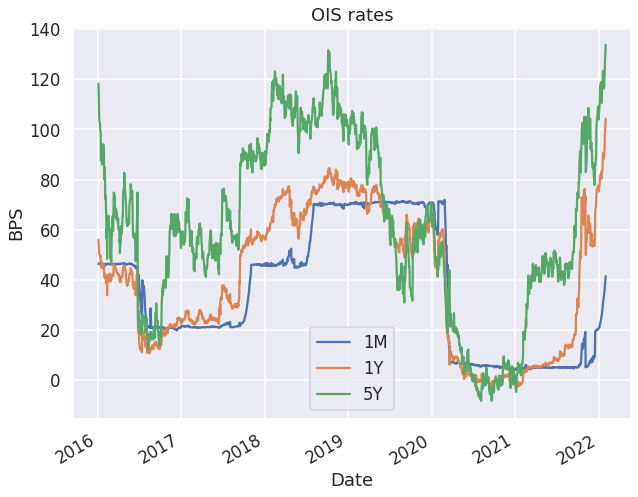

In [171]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/OIS%20spot.csv'
sonia_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/SONIA.csv'

def tenor_parser(month_number: int):
  years = np.floor(month_number/12)
  months = (month_number - 12*years)

  y_str = f"{int(years)}Y" * int(years > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + m_str
  
def rev_tenor_parser(month_sign: str):
    if 'Y' in month_sign and 'M' in month_sign:
      y = int(month_sign.split('Y')[0])
      m = int(month_sign.split('Y')[1].split('M')[0])
    elif 'Y' not in month_sign and 'M' in month_sign:
      y = 0
      m = int(month_sign.split('M')[0])
    elif 'Y' in month_sign and 'M' not in month_sign:
      y = int(month_sign.split('Y')[0])
      m = 0
    elif month_sign == 'SONIA':
      y = 0
      m = 0
    else:
      raise ValueError(f'Cannot parse tenor: {month_sign}')
    return 12*y + m


# OIS load
ois = pd.read_csv(ois_url,
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois.sort_index()*100.0
ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

# SONIA load
sonia = pd.read_csv(sonia_url,
                    index_col=['Date'], parse_dates=True, dayfirst=True)
sonia = sonia.sort_index()* 100.0

# Concatenate
rates = pd.concat([sonia, ois], axis = 1).dropna()

rates.iloc[:, [1, 12, 60]].plot()
plt.title('OIS rates')
plt.ylabel('BPS')
plt.xlabel('Date');

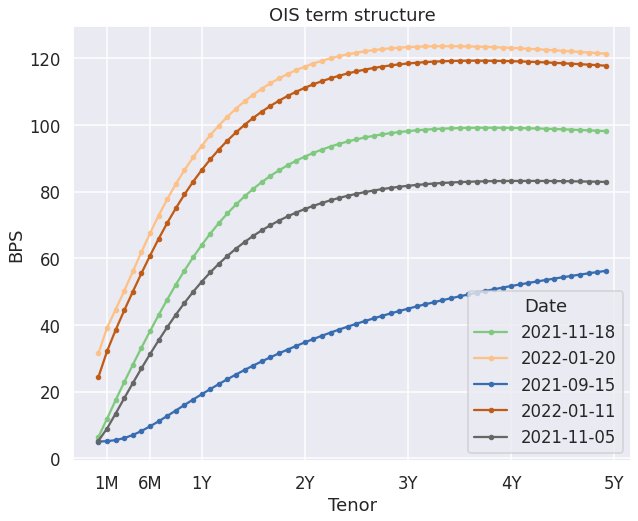

In [173]:
term_structure_df = rates.drop(['SONIA'], axis=1).tail(100).sample(5).T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.', cmap='Accent')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')
tenors = ['1M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y']
plt.xticks([rev_tenor_parser(x) for x in tenors], tenors);

# Model indexu SONIA

Sterling Overnight Index Average (SONIA) to alternatywna stopa referencyjna dla rynku dłużnego funta, która ma zastąpić GBP LIBOR po całkowitym jego wygaśnięciu.

SONIA obliczana jest jako średnia ucinana zaokrąglana do 4 miejsc po przecinku, brana na podstawie stóp procentowych obowiązujących na spełniających opowiednie warunki transakcjach depozytowych denominowanych w funcie sterlingu. 
Średnia ucinana używana do obliczania SONII jest ważona wolumenem, i bazowana na środkowych 50% rozkładu stóp procentowych. Transakcje brane pod uwage muszą być:

- Niesekurytyzowane i o jednodniowym terminie wygaśnięcia
- Wykonane między 00:00 and 18:00 czasu UK, o zapadalności transakcji tego samego dnia
- O wartości większej lub równej 25 mln funtów

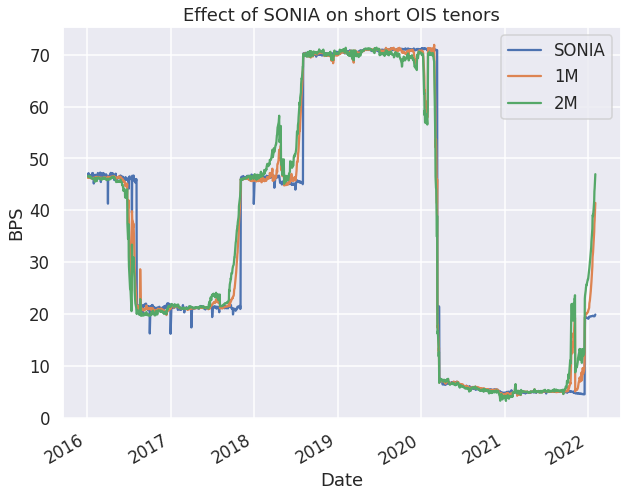

In [174]:
rates.iloc[:, :3].plot()
plt.title('Effect of SONIA on short OIS tenors')
plt.ylabel('BPS')
plt.xlabel('Date');

## Model Hulla-White'a

$$ dr_t = b(\mu_t - r_t)dt + \sigma dW_t$$ 


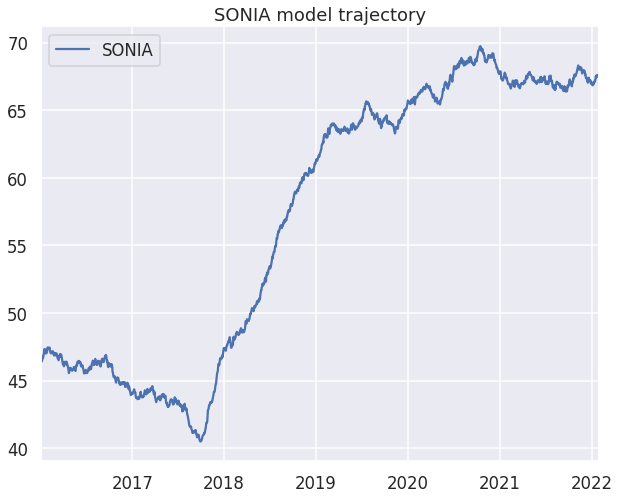

In [175]:
class HullWhiteModel():
    
    def __init__(self, b, mu_t, sigma):
        self.b = b
        self.mu_t = mu_t
        self.sigma = sigma

    def simulate(self,
                 x0, dates):
    
        dt = 1/255.
        xt = [x0.values[0]]
        t = [x0.index[0]]
        for i, date in enumerate(dates):
            x_k = xt[-1] + self.b*(self.mu_t(t[-1]) - xt[-1])*dt + self.sigma*np.random.randn()*np.sqrt(dt) # standard_t(df=2)
            xt.append(x_k)
            t.append(date)
        simulated_vals = pd.DataFrame(xt[1:], index = t[1:], columns = ['SONIA'])
        simulated_vals = pd.concat([x0, simulated_vals], axis=0)
        return simulated_vals

dates = ois.index[1:]

def mu_t(date):
    if date < np.datetime64('2016-09-01'):
        return sonia.iloc[0]
    elif date < np.datetime64('2017-10-01'):
        return sonia.iloc[0] - 5.
    elif date < np.datetime64('2018-06-01'):
        return sonia.iloc[0] + 10.
    else:
        return sonia.iloc[0] + 20.

model = HullWhiteModel(b = 2.0, # 70.0
                       mu_t = mu_t,
                       sigma = 2.0) # 2.0

xt = model.simulate(dates = dates,
                    x0 = sonia.iloc[[0], :])

xt.plot()
plt.title('SONIA model trajectory');

## Jak polityka BoE wpływa na krzywą OIS?

- [BoE rate](https://www.bankofengland.co.uk/monetary-policy/the-interest-rate-bank-rate)
- [SONIA rate](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N)

## Model indexu SONIA, na podstawie BoE rate

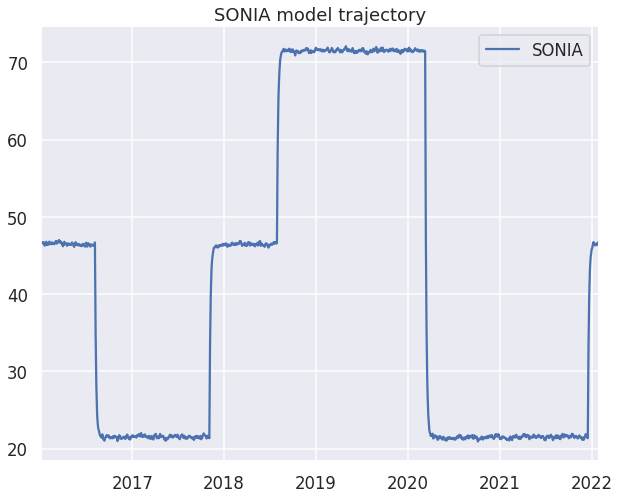

In [176]:
def boe_rate_pred(date):
    if date < np.datetime64('2016-08-05'):
        return sonia.iloc[0]
    elif date < np.datetime64('2017-11-03'):
        return sonia.iloc[0] - 25.
    elif date < np.datetime64('2018-07-31'):
        return sonia.iloc[0] + 0.
    elif date < np.datetime64('2020-03-11'):
        return sonia.iloc[0] + 25.
    elif date < np.datetime64('2020-03-20'):
        return sonia.iloc[0] - 25.
    elif date < np.datetime64('2020-03-20'):
        return sonia.iloc[0] - 40.
    elif date < np.datetime64('2021-12-17'):
        return sonia.iloc[0] - 25.
    else:
        return sonia.iloc[0] + 0.

sonia_model = HullWhiteModel(b = 70.0,
                             mu_t = boe_rate_pred,
                             sigma = 2.0)

sonia_sim = sonia_model.simulate(dates = dates,
                                 x0 = sonia.iloc[[0], :])

sonia_sim.plot()
plt.title('SONIA model trajectory');

# Długa krzywa OIS



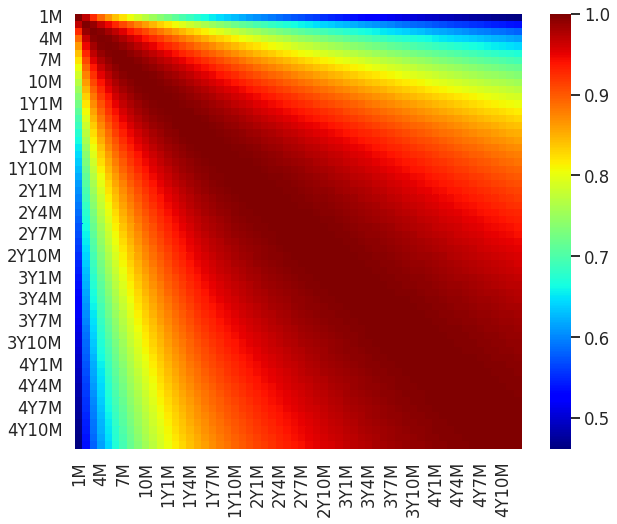

In [177]:
diffs = (rates[ois.columns].sub(rates['SONIA'], axis=0)).diff().dropna()

sns.heatmap(diffs.corr(), cmap='jet')

## PCA

### Idea


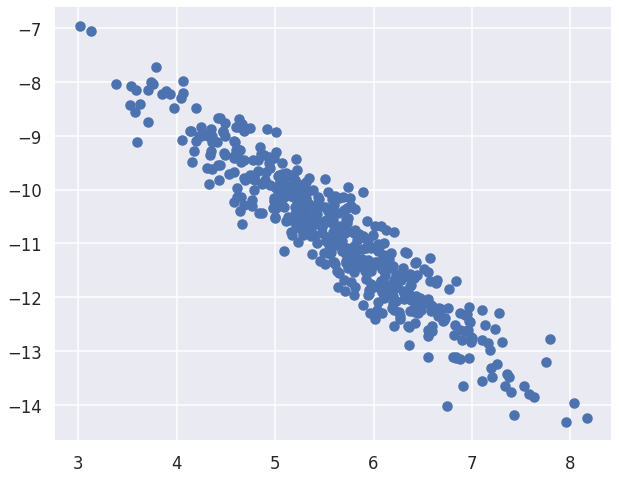

In [32]:
X, _ = make_blobs(n_samples=[500],  random_state=42)
transformation = [[-0.8, 0.9], [0.4, -0.95]]
X = np.dot(X, transformation)
plt.scatter(X[:, 0], X[:, 1]);

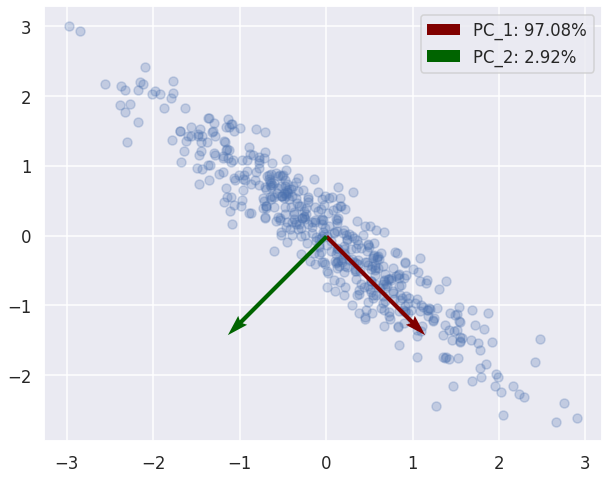

In [33]:
pca = PCA(2)

X = (X - X.mean(axis=0))/X.std(axis=0)
origin =  X.mean(axis=0)
pca.fit(X)
V = pca.components_

plt.scatter(X[:, 0], X[:, 1], alpha = 0.25)
plt.quiver(*origin, V[0, 1], V[0, 0],
           scale = 4,
           color='maroon', label=f'PC_1: {pca.explained_variance_ratio_[0]:.2%}')
plt.quiver(*origin, V[1, 1], V[1, 0],
           scale = 4,
           facecolor='darkgreen', label=f'PC_2: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend()
plt.show()

### Zastosowanie do krzywej OIS

In [178]:
long_tenors = ois.columns[0:]
long_tenors

Index(['1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M',
       '1Y', '1Y1M', '1Y2M', '1Y3M', '1Y4M', '1Y5M', '1Y6M', '1Y7M', '1Y8M',
       '1Y9M', '1Y10M', '1Y11M', '2Y', '2Y1M', '2Y2M', '2Y3M', '2Y4M', '2Y5M',
       '2Y6M', '2Y7M', '2Y8M', '2Y9M', '2Y10M', '2Y11M', '3Y', '3Y1M', '3Y2M',
       '3Y3M', '3Y4M', '3Y5M', '3Y6M', '3Y7M', '3Y8M', '3Y9M', '3Y10M',
       '3Y11M', '4Y', '4Y1M', '4Y2M', '4Y3M', '4Y4M', '4Y5M', '4Y6M', '4Y7M',
       '4Y8M', '4Y9M', '4Y10M', '4Y11M', '5Y'],
      dtype='object')

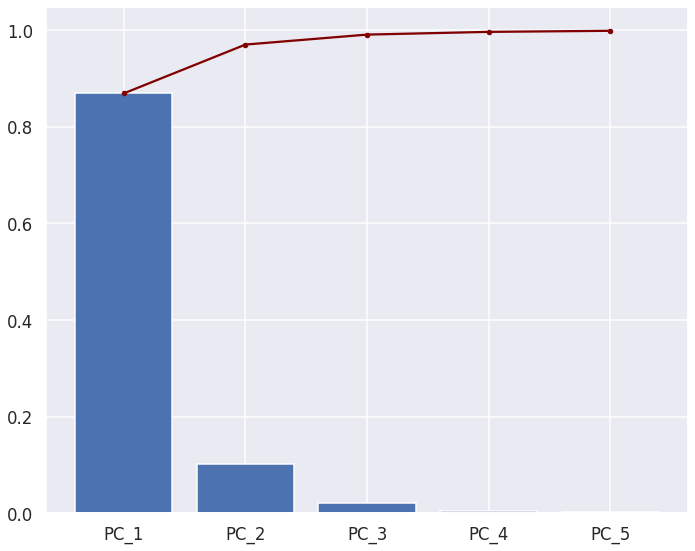

In [35]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
diffs = (rates[long_tenors].sub(rates['SONIA'], axis=0)).diff().dropna()
diffs = rates[long_tenors].diff().dropna()
sc.fit(diffs)

diffs_sc = sc.transform(diffs)
pca = PCA()
pca.fit(diffs_sc)

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
exp_var['Cumulative explained variance'] = pca.explained_variance_ratio_.cumsum()

max_n = 5
plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
plt.tight_layout()

In [36]:
exp_var.head(10)

,Explained variance,Cumulative explained variance
PC_1,0.869378,0.869378
PC_2,0.101047,0.970425
PC_3,0.020670,0.991095
PC_4,0.005634,0.996729
PC_5,0.002199,0.998929
PC_6,0.000664,0.999592
PC_7,0.000280,0.999873
PC_8,0.000091,0.999963
PC_9,0.000027,0.999990
PC_10,0.000007,0.999998


In [179]:
class PCA_term_structure():
    plot_tenors = {'1M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y'}

    def __init__(self, 
                 pca_num: int = 3, cutoff_tenor: str ='1Y'):
        self.pca_num=pca_num
        self.cutoff_tenor= cutoff_tenor


    def fit(self, data):
        tenor_data = data.drop(['SONIA'], axis=1).loc[:, self.cutoff_tenor:]
        sonia_spreads = tenor_data.sub(data['SONIA'], axis=0)
        
        self.data = {'raw': data,
                     'sonia_spreads': sonia_spreads,
                     'diffs': sonia_spreads.diff().dropna(),
                     'T0': data.iloc[[0], :]}
        
        self.scaler = StandardScaler()
        self.scaler.fit(self.data['diffs'])
        self.data['diffs_scaled'] = self.scaler.transform(self.data['diffs'])
        
        self.pca = PCA(self.pca_num)
        self.pca.fit(self.data['diffs_scaled'])
        self.data['diffs_pca'] = self.pca.transform(self.data['diffs_scaled'])
        
        self.modelled_tenors = tenor_data.columns
        self.components = pd.DataFrame(self.pca.components_, 
                                       columns = tenor_data.columns,
                                       index=[f'PC_{i + 1}' for i in range(self.pca.n_components)]).T
        
    def plot_loadings(self):
        self.components.plot(marker='.')
        tenors_str = set(self.data['sonia_spreads']) & self.plot_tenors
        tenors_int = sorted([rev_tenor_parser(x) for x in tenors_str])
        plt.xticks(tenors_int, [tenor_parser(x) for x in tenors_int])
        
    def plot_explained_variance(self):
        exp_var = pd.DataFrame(self.pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(self.pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
        exp_var['Cumulative explained variance'] = self.pca.explained_variance_ratio_.cumsum()

        max_n = 5
        plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
        plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
        plt.tight_layout()
        
    def plot_components(self):
        data_pca = pd.DataFrame(self.data['diffs_pca'])
        data_pca.columns = [f'PC_{i+1}' for i in range(self.pca_num)]
        data_pca.index = self.data['diffs'].index
        data_pca.plot(subplots=True)
        plt.suptitle('Differences in the PCA feature space', y =0.92)
        
    def simulate(self,
                 dates, x0, 
                 sonia_scenario=None):
      
        if len(set(self.modelled_tenors) - set(x0.columns)):
          raise ValueError(f'Missing jumpoff tenors: {set(self.modelled_tenors) - set(x0.columns)}')

        data_pca = pd.DataFrame(self.data['diffs_pca'])
        bootstrap_sample = data_pca.sample(len(dates), replace=True)
        bootstrap_sample.index = dates

        diff_scaled_sim = pd.DataFrame(self.pca.inverse_transform(bootstrap_sample))
        diff_sim = pd.DataFrame(self.scaler.inverse_transform(diff_scaled_sim))

        diff_sim.columns = self.modelled_tenors
        diff_sim.index = dates

        ois_sim = pd.concat([x0, diff_sim], axis=0).cumsum(axis=0)

        if sonia_scenario is not None:
            ois_sim += sonia_scenario.values
        else:
            ois_sim += self.data['raw'][['SONIA']].values
        return ois_sim

long_term_model = PCA_term_structure(pca_num = 3, cutoff_tenor = '1M' )
long_term_model.fit(rates)

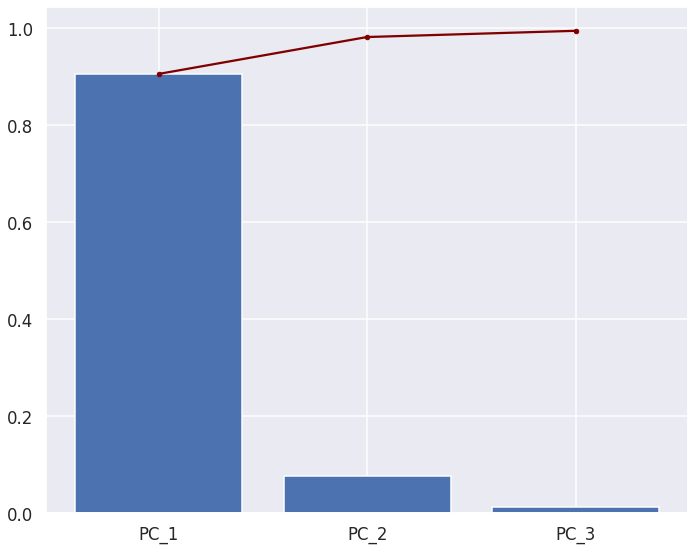

In [180]:
long_term_model.plot_explained_variance()

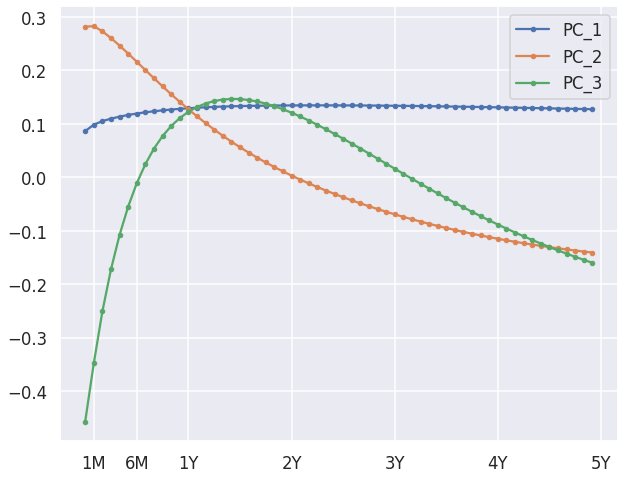

In [181]:
long_term_model.plot_loadings()

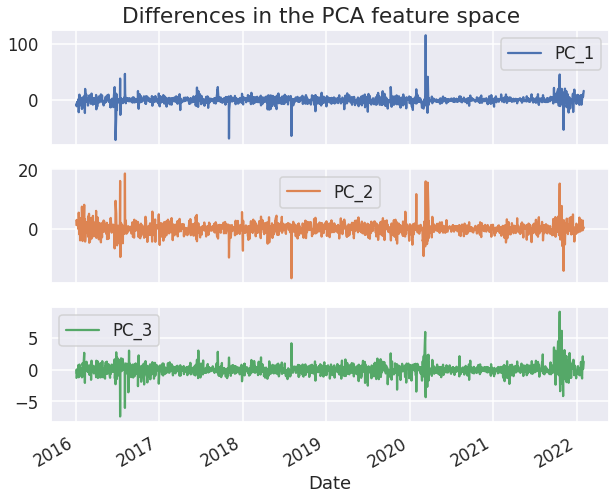

In [182]:
long_term_model.plot_components()

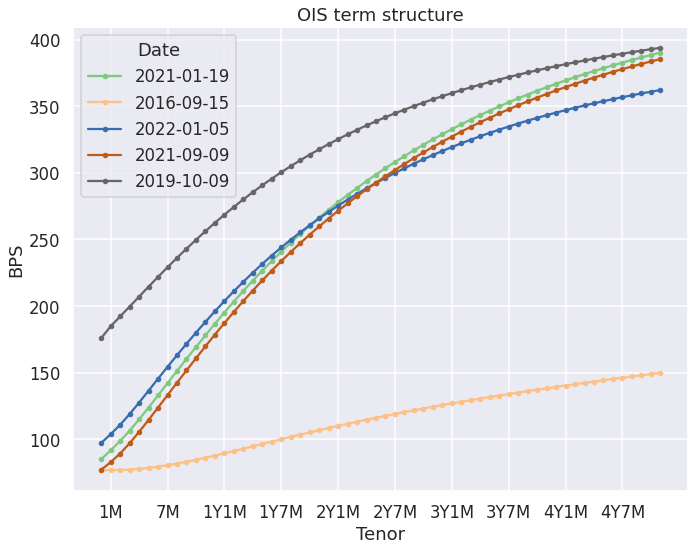

In [184]:
simulation = long_term_model.simulate(dates = rates.index[1:], x0 = rates.iloc[[0], 1:])

#term_structure_df = simulation.tail(100).resample('M').last().T
term_structure_df = simulation.sample(5).T

term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.', cmap='Accent')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')
tenors = long_term_model.modelled_tenors[::6]
plt.xticks([rev_tenor_parser(x) for x in tenors], tenors, rotation='horizontal');
plt.tight_layout()

## Krótka krzywa OIS

Krótkie tenory krzywej OIS modeluje się osobno od reszty krzywej, ponieważ z powodu dużego wpływu SONII, zachowują się one inaczej od długoterminowych tenorów.

Zastosujemy podejście pivots, modelując 6M tenor, przy pomocy SONII i tenorów bliskich 1Y. Brakujące tenory zostaną zinterpolowane.

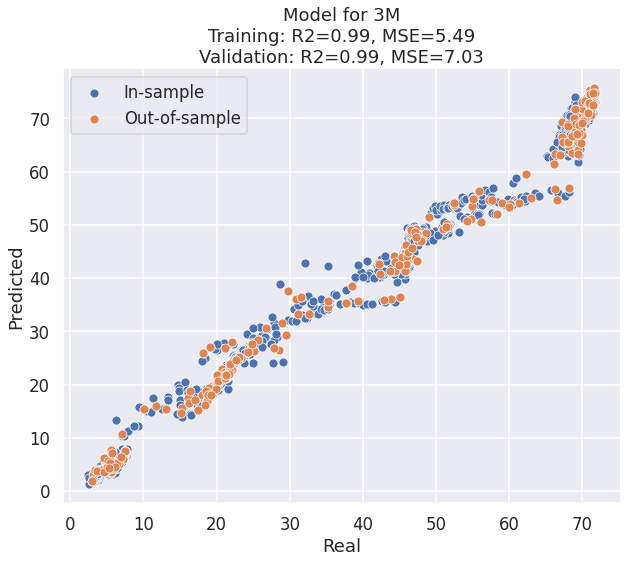

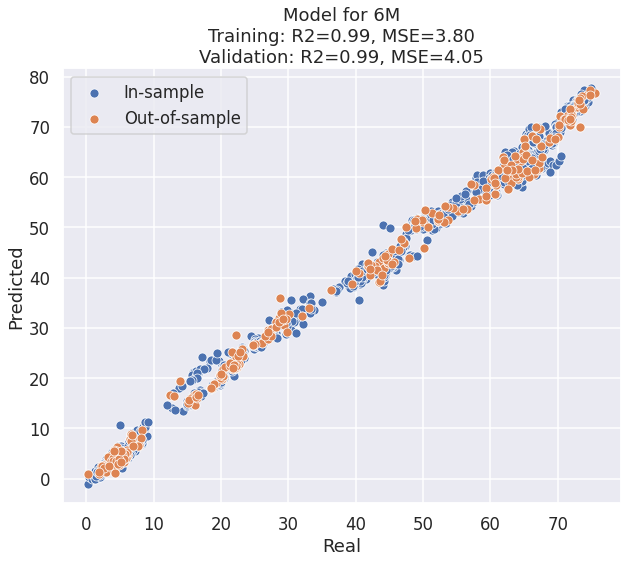

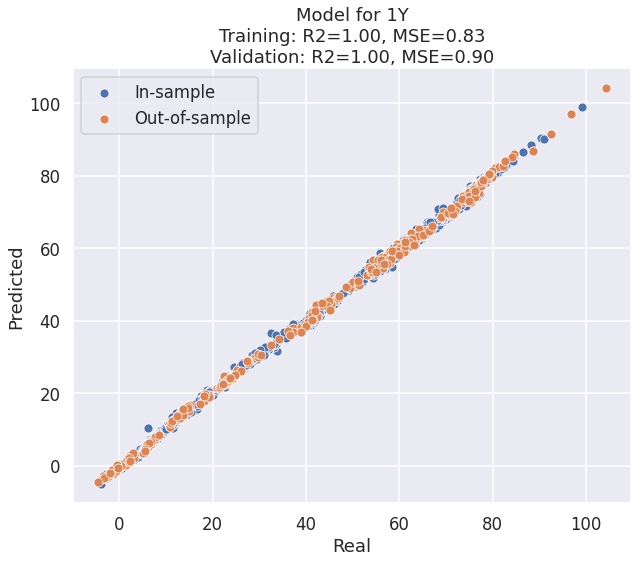

In [319]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, r2_score)
from scipy.interpolate import CubicSpline, interp1d

class RegressionShortTermModel():

    def __init__(self, pivot_tenors, cutoff):
        self.pivot_tenors = pivot_tenors
        self.cutoff = cutoff

    @staticmethod
    def build_models(pivot_tenors):
        model = {pivot: Pipeline([('scaler', StandardScaler()),
                                  ('poly', PolynomialFeatures(2)),
                                  ('regressor', LassoCV(max_iter=1000000))]) for pivot in pivot_tenors}
        return model
    
    def extract_features(self, data, X_only=False):
        features = data.loc[:, self.cutoff:].columns[::10]

        X = {pivot: data.loc[:, features] for pivot in self.pivot_tenors}
        for pivot, X_train in X.items():
          X_train[f'SONIA-{self.cutoff} spread'] = data['SONIA'] - data[self.cutoff]
          X_train[f'Skewness factor'] = data['5Y'] - data[self.cutoff]
          X_train[f'Convexity factor'] = (data['5Y'] + data[self.cutoff])/2.0 - data['3Y']
          
          
        if X_only:
          return X
        y = {pivot: data[[pivot]].values for pivot in self.pivot_tenors}
        return X, y

    def fit(self, data, val_split=None):
        self.models = self.build_models(self.pivot_tenors)
        X_dict, y_dict = self.extract_features(data)
        self.train_data = (X_dict, y_dict)

        coefs = {}
        for pivot in self.pivot_tenors:
          X_train = X_dict[pivot]
          y_train = y_dict[pivot]        
          if val_split is not None:
            X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                              y_train,
                                                              test_size=val_split)
          self.models[pivot].fit(X_train, y_train.ravel())
          coefs[pivot] = pd.DataFrame(self.models[pivot][-1].coef_,
                                      index = self.models[pivot][:-1].get_feature_names_out(),
                                      columns=['Coefficient'])
          coefs[pivot] = coefs[pivot][np.abs(coefs[pivot]).values > 0.0]
          self.coef_ = coefs

          if val_split is not None:
            self.validate_model(pivot, X_val, y_val)
    
    def predict(self, X, tenors):
        X_pred = self.extract_features(X, X_only=True)
        preds = []
        for pivot in tenors:
          if pivot not in self.pivot_tenors:
            raise ValueError(f'Tenor {pivot} is not modelled.')

          pivot_sim = pd.DataFrame(self.models[pivot].predict(X_pred[pivot]))
          pivot_sim.index = X.index
          pivot_sim.columns = [pivot]
          preds.append(pivot_sim)
        return pd.concat(preds, axis=1)


    def validate_model(self, pivot, X_val, y_val):
        X_train, y_train = self.train_data

        fig, ax = plt.subplots()
        y_pred= self.models[pivot].predict(X_train[pivot])
        sns.scatterplot(x = y_train[pivot].ravel(),
                        y = y_pred.ravel(), label = 'In-sample')
        plt.xlabel('Real')
        plt.ylabel('Predicted')

        train_r2 = r2_score(y_train[pivot], y_pred)
        train_mse = mean_squared_error(y_train[pivot], y_pred)

        y_pred= self.models[pivot].predict(X_val)
        sns.scatterplot(x = y_val.ravel(), 
                        y = y_pred.ravel(), label = 'Out-of-sample')

        val_r2 = r2_score(y_val, y_pred)
        val_mse = mean_squared_error(y_val, y_pred)

        plt.legend()
        plt.title(f'Model for {pivot}\nTraining: R2={train_r2:.2f}, MSE={train_mse:.2f}\nValidation: R2={val_r2:.2f}, MSE={val_mse:.2f}')
    
    def spline(self, rates, kind='quadratic'):
        available_tenors_str = rates.columns
        available_tenors_int = [rev_tenor_parser(tenor_str) for tenor_str in available_tenors_str]
        sp = interp1d(np.array(available_tenors_int), rates.values, kind = kind)
        interpolated = pd.concat([pd.DataFrame(sp(tenor)) for tenor in range(0, 61)], axis=1)
        interpolated.columns = ['SONIA'] + list(ois.columns)
        interpolated.index = rates.index
        return interpolated

    def simulate(self, long_tenor_data):
        X = self.extract_features(long_tenor_data, X_only=True)
        preds = []
        for pivot in self.pivot_tenors:
          pivot_sim = pd.DataFrame(self.models[pivot].predict(X[pivot])).T
          pivot_sim.index = long_tenor_data.index[1:]
          pivot_sim.columns = [pivot]
          preds.append(pivot_sim)
        return pd.concat(preds, axis=1)


short_term_model = RegressionShortTermModel(pivot_tenors=['3M', '6M', '1Y'], cutoff='2Y')
short_term_model.fit(rates, val_split=0.2)

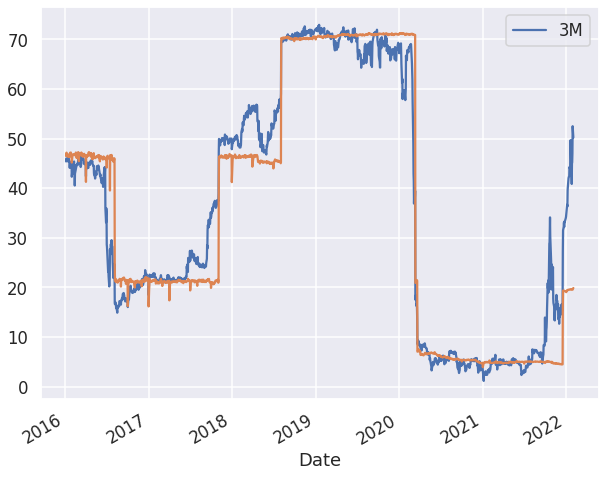

In [295]:
short_term_model.predict(X=rates, tenors=['3M']).plot()
rates['SONIA'].plot()

# Monte Carlo



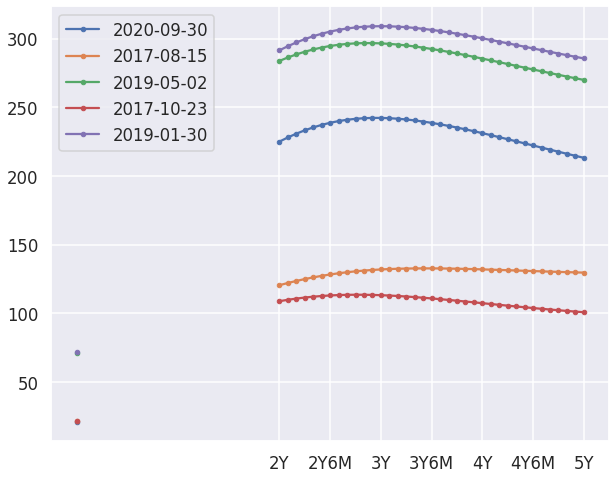

In [350]:
%matplotlib inline
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10, 8)

# Simulate SONIA
sonia_sim = sonia_model.simulate(dates=rates.diff().dropna().index,
                                 x0=sonia.iloc[[0], :])

# Simulate long OIS tenors
cutoff_tenor = '2Y'
long_term_model = PCA_term_structure(pca_num = 3, cutoff_tenor = cutoff_tenor)
long_term_model.fit(data=rates)

long_term_sim = long_term_model.simulate(dates=rates.diff().dropna().index,
                                         x0=rates.loc[:, cutoff_tenor:].iloc[[0], :],
                                         sonia_scenario = sonia_sim)

temp_sim = pd.concat([sonia_sim, long_term_sim], axis=1)
plot_df = pd.concat([rates.iloc[[0], :], temp_sim], axis = 0).iloc[1:, :].sample(5)
plot_df.index = plot_df.index.strftime('%Y-%m-%d')
plot_df.T.plot(marker='.')

tenors = long_term_model.modelled_tenors[::6]
plt.xticks([rev_tenor_parser(t) for t in tenors], tenors);

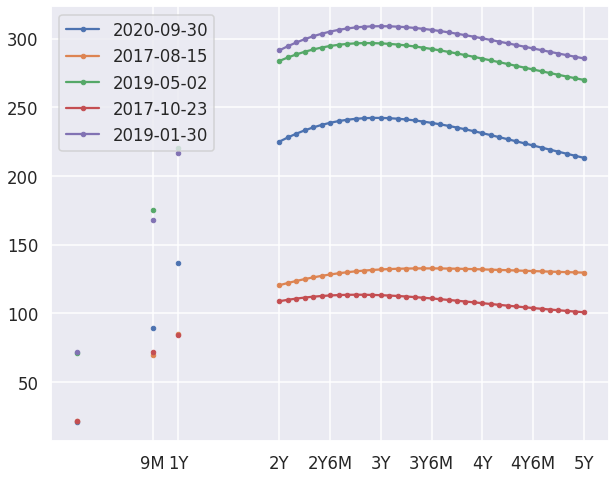

In [355]:
pivots = ['9M', '1Y']
short_term_model = RegressionShortTermModel(pivot_tenors=pivots,
                                            cutoff=cutoff_tenor)
short_term_model.fit(rates)

plot_df_2 = plot_df.copy()
for pivot in pivots:
  plot_df_2[pivot] = short_term_model.predict(X = plot_df, tenors=[pivot])

plot_df_2.T.plot(marker='.')
tenors = short_term_model.pivot_tenors + list(long_term_model.modelled_tenors[::6])
plt.xticks([rev_tenor_parser(t) for t in tenors], tenors)
plt.legend();

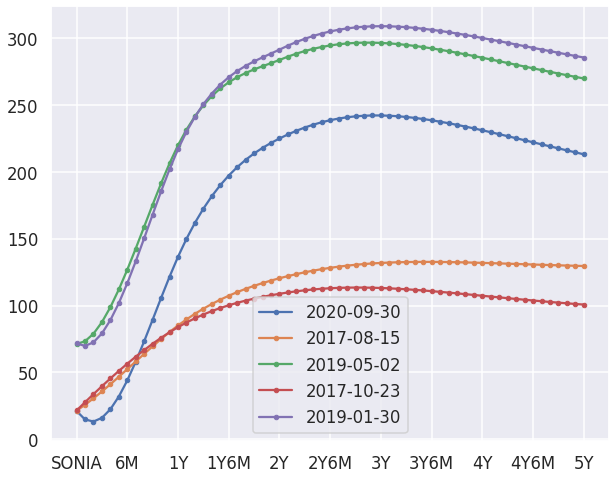

In [356]:
# Interpolate other tenors
simulation = short_term_model.spline(plot_df_2.dropna(axis=1), kind='cubic')

simulation.T.plot(marker='.')
tenors = rates.columns[::6]
plt.xticks([rev_tenor_parser(t) for t in tenors], tenors);

In [366]:
%matplotlib inline
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10, 8)

# Simulate SONIA
sonia_sim = sonia_model.simulate(dates=rates.diff().dropna().index,
                                 x0=sonia.iloc[[0], :])

# Simulate long OIS tenors
cutoff_tenor = '2Y'
long_term_model = PCA_term_structure(pca_num = 3, cutoff_tenor = cutoff_tenor)
long_term_model.fit(data=rates)

long_term_sim = long_term_model.simulate(dates=rates.diff().dropna().index,
                                         x0=rates.loc[:, cutoff_tenor:].iloc[[0], :],
                                         sonia_scenario = sonia_sim)

temp_sim = pd.concat([sonia_sim, long_term_sim], axis=1)

# Simulate pivots
pivots = ['9M', '1Y']
short_term_model = RegressionShortTermModel(pivot_tenors=pivots,
                                            cutoff=cutoff_tenor)
short_term_model.fit(rates)

for pivot in pivots:
  temp_sim[pivot] = short_term_model.predict(X = temp_sim, tenors=[pivot])

# Interpolate other tenors
simulation = short_term_model.spline(temp_sim, kind='cubic')

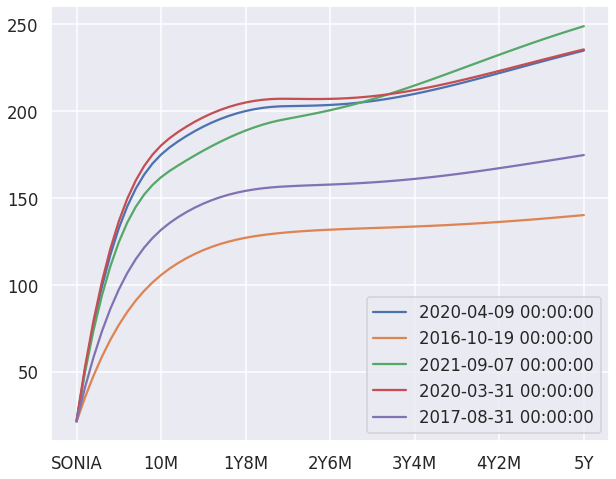

In [376]:
simulation.sample(5).T.plot()

In [378]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([])     
ax.set_xlim(-2.95, 61.95)
ax.set_ylim(simulation.min().min()*0.9, simulation.max().max()*1.1)
tenors = np.array([3, 6, 9, 12, 24, 36, 48, 60])
plt.xticks(tenors, simulation.columns[tenors]);

def animate(frame_num):
    y = simulation.iloc[[frame_num], :].T
    x = list(range(len(y)))
    line.set_data((x, y))
    line.set_marker('.')
    plt.title(y.columns[0].strftime("%Y-%b-%d"))
    return line

anim = FuncAnimation(fig, animate, frames=len(simulation.index),
                     interval=40, blit=True, repeat=False)

from IPython.display import HTML
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
